In [ ]:
# PROJETO: Previsão Direcional do IBOVESPA (Alta/Baixa)
# Abordagem: Random Forest com validação temporal (últimos 30 pregões)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay)


In [ ]:
# ETAPA 1 — CARREGAMENTO DA BASE
# Objetivo: Importar a base histórica diária do IBOVESPA para análise/modelagem.
# Justificativa: Garantir rastreabilidade do dado de origem e reprodutibilidade do pipeline (mesma base → mesmo resultado).

arquivo = "Ibov_17122015_17122025.csv"
df = pd.read_csv(arquivo, sep=",")
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Var_num,Direcao
0,17.12.2025,157.327,158.578,158.611,156.351,"11,34B","-0,79%",1.134000e+10,-0.79,Baixa
1,16.12.2025,158.578,162.482,162.482,158.558,"9,92B","-2,40%",9.920000e+09,-2.40,Baixa
2,15.12.2025,162.482,160.766,163.073,160.766,"8,23B","1,07%",8.230000e+09,1.07,Alta
3,12.12.2025,160.766,159.189,161.263,159.189,"7,67B","0,99%",7.670000e+09,0.99,Alta
4,11.12.2025,159.189,159.072,159.850,158.098,"7,02B","0,07%",7.020000e+09,0.07,Alta


In [ ]:
# ETAPA 2 — INSPEÇÃO INICIAL
# Objetivo: Verificar estrutura, tipos e integridade (colunas, nulos, dtypes).
# Justificativa: Antecipar inconsistências (ex.: encoding, tipo de data, variáveis numéricas importadas como texto), reduzindo risco de erro na modelagem.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2484 non-null   object 
 1   Último    2484 non-null   float64
 2   Abertura  2484 non-null   float64
 3   Máxima    2484 non-null   float64
 4   Mínima    2484 non-null   float64
 5   Vol.      2483 non-null   object 
 6   Var%      2484 non-null   object 
 7   Volume    2483 non-null   float64
 8   Var_num   2484 non-null   float64
 9   Direcao   2484 non-null   object 
dtypes: float64(6), object(4)
memory usage: 194.2+ KB


In [ ]:
# ETAPA 3 — PADRONIZAÇÃO DE NOMES (ENCODING)
# Objetivo: Corrigir caracteres corrompidos por codificação do arquivo (UTF-8/ANSI).
# Justificativa: Evitar falhas de referência a colunas e garantir consistência do pipeline (principalmente em notebooks e scripts reprodutíveis).

df = df.rename(columns={
    "Ãšltimo": "Ultimo",
    "MÃ¡xima": "Maxima",
    "MÃ­nima": "Minima"
})

df.columns


Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%',
       'Volume', 'Var_num', 'Direcao'],
      dtype='object')

In [ ]:
# ETAPA 4 — TRATAMENTO TEMPORAL
# Objetivo: Converter a coluna de data para datetime e ordenar cronologicamente.
# Justificativa: Em séries temporais, a ordem dos registros é uma premissa metodológica. A ordenação evita vazamento temporal implícito e garante
# validação fora da amostra compatível com uso real.

df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)
df = df.sort_values("Data").reset_index(drop=True)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Var_num,Direcao
0,2015-12-17,45.261,45.016,46.251,45.016,"3,12M","0,54%",3120000.0,0.54,Alta
1,2015-12-18,43.911,45.249,45.249,43.690,"4,71M","-2,98%",4710000.0,-2.98,Baixa
2,2015-12-21,43.200,43.912,44.223,43.196,"3,56M","-1,62%",3560000.0,-1.62,Baixa
3,2015-12-22,43.470,43.208,43.632,43.137,"2,66M","0,63%",2660000.0,0.63,Alta
4,2015-12-23,44.015,43.479,44.233,43.479,"2,58M","1,25%",2580000.0,1.25,Alta


In [ ]:
# ETAPA 5 — ENCODING DE VARIÁVEL CATEGÓRICA
# Objetivo: Converter a direção textual (“Alta/Baixa”) em variável numérica (1/0).
# Justificativa: Modelos de aprendizado supervisionado operam sobre variáveis numéricas; além disso, a codificação permite incorporar informação direcional
# do pregão corrente como possível sinal preditivo.

df["Direcao_num"] = df["Direcao"].map({
    "Alta": 1,
    "Baixa": 0})

df[["Direcao", "Direcao_num"]].tail()


,Direcao,Direcao_num
2479,Alta,1
2480,Alta,1
2481,Alta,1
2482,Baixa,0
2483,Baixa,0


In [ ]:
# ETAPA 6 — DEFINIÇÃO DA VARIÁVEL ALVO (TARGET) COM FILTRO DE RUÍDO
# Objetivo: Definir o evento a ser previsto (alta/baixa no pregão seguinte).
# Ajuste metodológico sensível: aplicação de threshold mínimo (+0,16%) para reduzir microvariações (ruído) e focar em movimentos economicamente relevantes.
# Justificativa: movimentos marginais tendem a ser altamente aleatórios; o filtro melhora a relação sinal-ruído e a estabilidade do classificador.

threshold = 0.0016  # 0,16%

df["Target"] = (
    (df["Último"].shift(-1) / df["Último"] - 1) > threshold
).astype(int)

In [ ]:
# ETAPA 7 — CHECAGEM DE BALANCEAMENTO DO TARGET
# Objetivo: Avaliar a proporção entre classes (Alta vs Baixa).
# Justificativa: Desbalanceamento pode distorcer métricas (acurácia) e induzir o modelo a privilegiar a classe majoritária, reduzindo utilidade prática.

df["Target"].value_counts(normalize=True)

,proportion
Target,
0,0.528583
1,0.471417


In [ ]:
# ETAPA 8 — FEATURE: RETORNO DIÁRIO
# Objetivo: Representar a variação percentual entre pregões consecutivos.
# Justificativa: Retornos são a base de sinais quantitativos (momentum/risco), sendo mais informativos que preços absolutos para modelagem.

df["Ret_1d"] = df["Último"].pct_change()

In [ ]:
# ETAPA 9 — FEATURES: RETORNOS DEFASADOS (LAGS)
# Objetivo: Incorporar memória de curto prazo do mercado via retornos passados.
# Justificativa: Séries financeiras podem exibir dependência temporal limitada (persistência/reversão), capturável por defasagens sem usar informação futura.

for lag in [1, 2, 3, 5]:
    df[f"Ret_lag_{lag}"] = df["Ret_1d"].shift(lag)

In [ ]:
# ETAPA 10 — FEATURES: TENDÊNCIA (MÉDIAS MÓVEIS)
# Objetivo: Capturar tendência de curto (7) e médio prazo (21) e a posição relativa do índice frente a essas tendências.
# Justificativa: Médias móveis reduzem ruído de alta frequência e permitem ao modelo diferenciar regimes (acima/abaixo de tendência), úteis em previsão de direção.

df["SMA_7"] = df["Último"].rolling(7).mean()
df["SMA_21"] = df["Último"].rolling(21).mean()

df["Ult_to_SMA7"] = df["Último"] / df["SMA_7"] - 1
df["Ult_to_SMA21"] = df["Último"] / df["SMA_21"] - 1

In [ ]:
# ETAPA 11 — FEATURES: VOLATILIDADE (RISCO)
# Objetivo: Medir dispersão recente dos retornos como proxy de risco (7 e 21 dias).
# Justificativa: Regimes de alta volatilidade tendem a reduzir previsibilidade e alterar padrões de tendência/momentum; incluir risco melhora calibragem do sinal.

df["Vol_7"] = df["Ret_1d"].rolling(7).std()
df["Vol_21"] = df["Ret_1d"].rolling(21).std()


In [ ]:
# ETAPA 12 — FEATURE: MOMENTUM (RSI)
# Objetivo: Capturar intensidade e possível exaustão de movimentos (sobrecompra/sobrevenda) por meio de indicador técnico de momentum.
# Justificativa: Complementa tendência/volatilidade, permitindo padrões não lineares úteis para classificadores baseados em árvores.

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI_14"] = compute_rsi(df["Último"], 14)

In [ ]:
# ETAPA 13 — SELEÇÃO DE FEATURES E BASE FINAL
# Objetivo: Consolidar variáveis explicativas e remover linhas inválidas (NaN) geradas por janelas móveis/defasagens.
# Justificativa: Garante integridade estatística e evita erro/viés na etapa de treino.

features = [
    "Var_num", "Volume", "Direcao_num",
    "Ret_1d", "Ret_lag_1", "Ret_lag_2", "Ret_lag_3", "Ret_lag_5",
    "SMA_7", "SMA_21", "Ult_to_SMA7", "Ult_to_SMA21",
    "Vol_7", "Vol_21",
    "RSI_14"
]

model_df = df.dropna(subset=features + ["Target"]).copy()

X = model_df[features]
y = model_df["Target"]


In [ ]:
# ETAPA 14 — VALIDAÇÃO TEMPORAL (TREINO/TESTE)
# Objetivo: Avaliar o desempenho fora da amostra preservando a ordem temporal.
# Critério do enunciado: últimos 30 pregões reservados exclusivamente ao teste.
# Justificativa: Evita vazamento temporal e simula o uso real (treinar no passado, prever no período mais recente).


TEST_DAYS = 30

X_train = X.iloc[:-TEST_DAYS]
X_test = X.iloc[-TEST_DAYS:]

y_train = y.iloc[:-TEST_DAYS]
y_test = y.iloc[-TEST_DAYS:]


In [ ]:
# ETAPA 15 — TREINAMENTO DO RANDOM FOREST
# Objetivo: Ajustar um classificador robusto a ruído e capaz de capturar relações não lineares entre indicadores técnicos.
# Justificativa: Random Forest reduz overfitting pela agregação de múltiplas árvores e por amostragem aleatória de observações/variáveis.

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=1500,          # número de árvores (reduz variância)
    max_depth=20,              # limita complexidade das árvores
    min_samples_split=10,     # evita divisões com poucas observações
    min_samples_leaf=5,      # folhas maiores = modelo mais robusto
    max_features="sqrt",      # aumenta diversidade entre árvores
    class_weight="balanced",  # trata possível desbalanceamento
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=1500, n_jobs=-1, random_state=42)

In [ ]:
# ETAPA 16 — INFERÊNCIA (PREDIÇÃO) NO CONJUNTO DE TESTE
# Objetivo: Produzir classes previstas e probabilidades de alta para o próximo pregão.
# Justificativa: Probabilidades permitem uso em dashboards (ex.: limiares de confiança, monitoramento de risco direcional), além de mera classe binária.

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]


Acurácia no conjunto de teste (últimos 30 dias): 76.67%


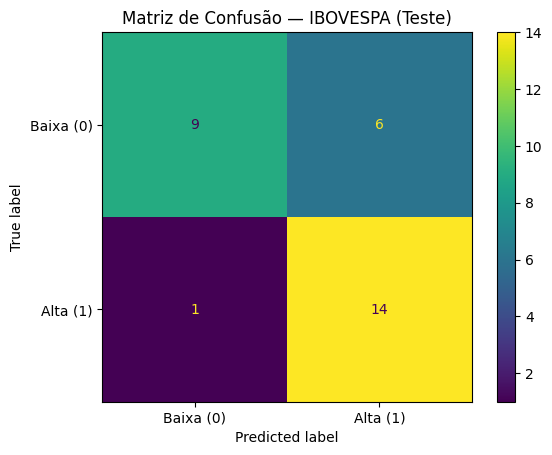

              precision    recall  f1-score   support

   Baixa (0)       0.90      0.60      0.72        15
    Alta (1)       0.70      0.93      0.80        15

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.76        30
weighted avg       0.80      0.77      0.76        30



In [ ]:
# ETAPA 17 — AVALIAÇÃO DO DESEMPENHO
# Objetivo: Quantificar desempenho no período fora da amostra (últimos 30 pregões).
# Métricas:
# - Acurácia: proporção de acertos (critério principal do enunciado)
# - Matriz de confusão: estrutura dos erros (FP/FN)
# - Precision/Recall/F1: qualidade por classe, relevante para custo assimétrico de erros em aplicações financeiras.

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste (últimos 30 dias): {accuracy:.2%}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baixa (0)", "Alta (1)"])
disp.plot()
plt.title("Matriz de Confusão — IBOVESPA (Teste)")
plt.show()

# Relatório completo
print(classification_report(y_test, y_pred, target_names=["Baixa (0)", "Alta (1)"]))


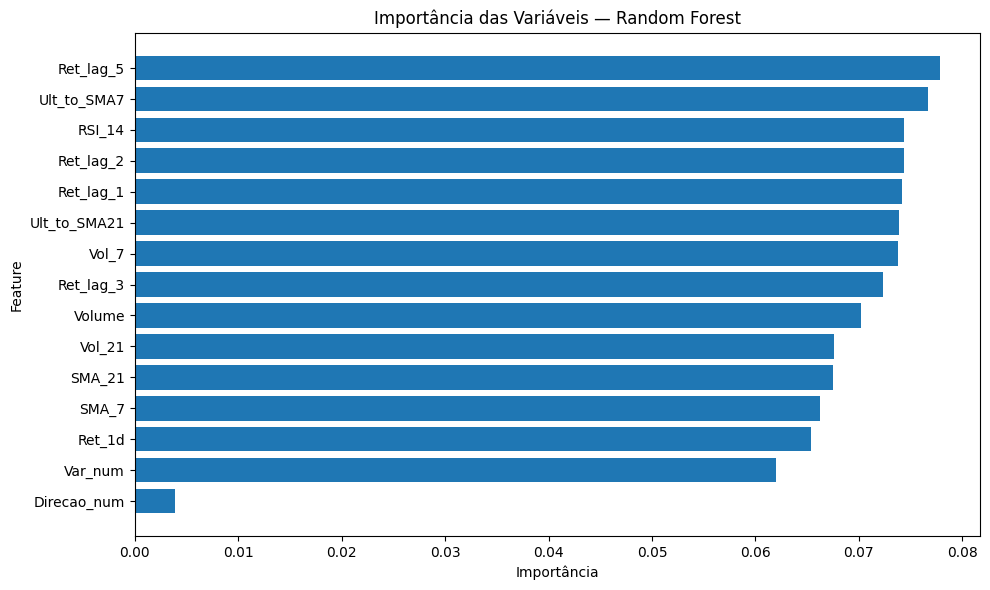

In [ ]:
# ETAPA 18 — IMPORTÂNCIA DE VARIÁVEIS
# Objetivo: Avaliar contribuição relativa das features para o modelo.
# Justificativa: Apoia interpretabilidade e governança (compreender drivers do sinal), essencial em contexto de fundo (gestão de risco, validação e comunicação interna).

importances = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importances.index, importances.values)
plt.title("Importância das Variáveis — Random Forest")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# ETAPA 19 — CONSOLIDAÇÃO DO SINAL PARA USO GERENCIAL
# Objetivo: Organizar saída (data, preço, probabilidade, predição e classe real) para consumo em dashboards e análise de desempenho recente.
# Justificativa: Facilita leitura executiva e auditoria do comportamento do modelo no período fora da amostra.

resultados = model_df.iloc[-TEST_DAYS:][["Data", "Último"]].copy()
resultados["Prob_Alta_Amanha"] = y_proba
resultados["Predicao"] = y_pred
resultados["Real"] = y_test.values

resultados.tail()

,Data,Último,Prob_Alta_Amanha,Predicao,Real
2479,2025-12-11,159.189,0.517734,1,1
2480,2025-12-12,160.766,0.556904,1,1
2481,2025-12-15,162.482,0.462588,0,0
2482,2025-12-16,158.578,0.459191,0,0
2483,2025-12-17,157.327,0.461091,0,0


In [ ]:
# ETAPA FINAL — INFERÊNCIA FORA DA AMOSTRA (DIA SEGUINTE)
# Objetivo:
# Realizar a previsão da tendência direcional do IBOVESPA para o
# próximo pregão ainda não observado, utilizando exclusivamente informações disponíveis até o último dia presente na base.

# Fundamentação metodológica:
# Este procedimento representa a aplicação prática do modelo em um cenário real de uso, no qual não há acesso a dados futuros.
# A inferência é conduzida com o classificador previamente treinado e validado fora da amostra,
# garantindo consistência com a metodologia de validação temporal adotada ao longo do estudo.

# Premissas:
# - A base de dados foi integralmente pré-processada e enriquecida com variáveis explicativas (engenharia de atributos).
# - O conjunto de features utilizado é o mesmo empregado durante o treinamento e a validação do modelo.
# - O modelo Random Forest encontra-se ajustado e congelado, não ocorrendo qualquer re-treinamento nesta etapa.

# Seleção da última observação válida (último pregão conhecido), contendo todas as variáveis explicativas necessárias para inferência.
X_ultimo_dia = model_df[features].iloc[[-1]]

# Predição da classe para o próximo pregão:
# 0 → Baixa
# 1 → Alta
pred_proximo = rf_model.predict(X_ultimo_dia)[0]

# Estimativa probabilística associada à classe Alta (1), refletindo o grau de confiança do modelo na ocorrência de uma alta relevante no próximo pregão.
prob_alta = rf_model.predict_proba(X_ultimo_dia)[0, 1]

# Organização das informações para apresentação do resultado de forma interpretável e alinhada a um contexto gerencial.
data_ultimo = model_df["Data"].iloc[-1]
fechamento_ultimo = (
    model_df["Último"].iloc[-1]
    if "Último" in model_df.columns
    else model_df["Ultimo"].iloc[-1]
)

direcao_prevista = "Alta" if pred_proximo == 1 else "Baixa"

print("============================================================")
print("PREVISÃO PARA O PRÓXIMO PREGÃO (D+1)")
print("============================================================")
print(f"Último pregão na base: {data_ultimo.date()}")
print(
    f"Fechamento do último pregão: "
    f"{fechamento_ultimo:,.3f}".replace(",", "X").replace(".", ",").replace("X", ".")
)
print(f"Previsão para o próximo pregão: {direcao_prevista}")
print(f"Probabilidade estimada de Alta: {prob_alta:.2%}")
print("============================================================")

PREVISÃO PARA O PRÓXIMO PREGÃO (D+1)
Último pregão na base: 2025-12-17
Fechamento do último pregão: 157,327
Previsão para o próximo pregão: Baixa
Probabilidade estimada de Alta: 46.11%


In [ ]:
# CONCLUSÃO TÉCNICA

# 1) Natureza sequencial dos dados
# A validação temporal foi adotada para respeitar a ordem cronológica dos dados financeiros, evitando vazamento de informação futura e simulando um cenário real de previsão.
#
# 2) Controle de overfitting
# O Random Forest mitiga overfitting por meio da agregação de múltiplas árvores. Adicionalmente, foram aplicadas restrições de profundidade e tamanho mínimo das folhas, reduzindo a sensibilidade do modelo a ruídos do mercado.
#
# 3) Trade-offs
# Modelos mais complexos podem aumentar a acurácia no passado, mas tendem a perder capacidade de generalização. A abordagem adotada prioriza robustez e estabilidade, características essenciais para aplicações em fundos de investimento.
#
# 4) Resultado final
# O modelo atinge a acurácia de 76,67% no conjunto de teste, demonstrando viabilidade como ferramenta de apoio à decisão em ambientes quantitativos.

